# Nukleus - exploring submasks

In [1]:
%matplotlib inline
import numpy as np
import xarray as xr

# use orography to look at the data
file = "/pool/data/CORDEX/data/cordex/output/EUR-11/GERICS/ECMWF-ERAINT/evaluation/r0i0p0/GERICS-REMO2015/v1/fx/orog/v20180813/orog_EUR-11_ECMWF-ERAINT_evaluation_r0i0p0_GERICS-REMO2015_v1_fx.nc"
ds = xr.open_dataset(file)
pollat = ds.rotated_latitude_longitude.grid_north_pole_latitude
pollon = ds.rotated_latitude_longitude.grid_north_pole_longitude

mask = xr.open_dataset("NUKLEUS_MASKEN_BTU-20210510.nc")
mask

<xarray.Dataset>
Dimensions:        (rlat: 412, rlon: 424, submask_index: 13)
Coordinates:
  * rlon           (rlon) float32 -28.38 -28.26 -28.16 ... 17.93 18.05 18.16
  * rlat           (rlat) float32 -23.38 -23.26 -23.16 ... 21.61 21.73 21.83
    submask_names  (submask_index) |S3 ...
Dimensions without coordinates: submask_index
Data variables:
    lon            (rlat, rlon) float32 ...
    lat            (rlat, rlon) float32 ...
    MASK           (submask_index, rlat, rlon) float32 ...
Attributes:
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    Conventions:     CF-1.0
    history:         Mon May 10 13:57:14 2021: cdo delete,level=1,2,3,4,5,6,7...
    source:          regiomask v1.0 part of the BTU evaluation tools, contact...
    institution:     Chair of Environmental Meteorology, Brandenburg Universi...
    conventionsURL:  http://www.cgd.ucar.edu/cms/eaton/cf-metadata/index.html
    experiment_id:   NUKLEU
    title:           Masks used for evaluation of CLM simulations at GRD311
    creation_date:   2020-10-30 14:21:28
    grid_id:         GRD311
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

fix inconsistencies, make submask a coordinate for convenience:

In [2]:
# fix inconsistencies, make submask a coordinate for convenience:
# mask = mask.rename({'submask_names':'submask', 'submask_index':'submask'})
mask = mask.swap_dims({"submask_index": "submask_names"}).rename(
    {"submask_names": "submask"}
)
mask["submask"] = mask.submask.astype(str)
mask

<xarray.Dataset>
Dimensions:  (rlat: 412, rlon: 424, submask: 13)
Coordinates:
  * rlon     (rlon) float32 -28.38 -28.26 -28.16 -28.05 ... 17.93 18.05 18.16
  * rlat     (rlat) float32 -23.38 -23.26 -23.16 -23.05 ... 21.61 21.73 21.83
  * submask  (submask) <U3 'KLK' 'WAG' 'WAL' 'WAW' ... 'DUI' 'REA' 'REN' 'RES'
Data variables:
    lon      (rlat, rlon) float32 ...
    lat      (rlat, rlon) float32 ...
    MASK     (submask, rlat, rlon) float32 ...
Attributes:
    CDI:             Climate Data Interface version 1.9.5 (http://mpimet.mpg....
    Conventions:     CF-1.0
    history:         Mon May 10 13:57:14 2021: cdo delete,level=1,2,3,4,5,6,7...
    source:          regiomask v1.0 part of the BTU evaluation tools, contact...
    institution:     Chair of Environmental Meteorology, Brandenburg Universi...
    conventionsURL:  http://www.cgd.ucar.edu/cms/eaton/cf-metadata/index.html
    experiment_id:   NUKLEU
    title:           Masks used for evaluation of CLM simulations at GRD311
    creation_date:   2020-10-30 14:21:28
    grid_id:         GRD311
    CDO:             Climate Data Operators version 1.9.5 (http://mpimet.mpg....

the coordinates of the mask file and the ESGF dataset are not identical (because of different precision). we fix this here so that we can use the mask file in the where function. let's just copy the original coordinates to the mask dataset.

In [3]:
mask.coords["rlon"] = ds.rlon
mask.coords["rlat"] = ds.rlat
mask.coords["lon"] = ds.lon
mask.coords["lat"] = ds.lat

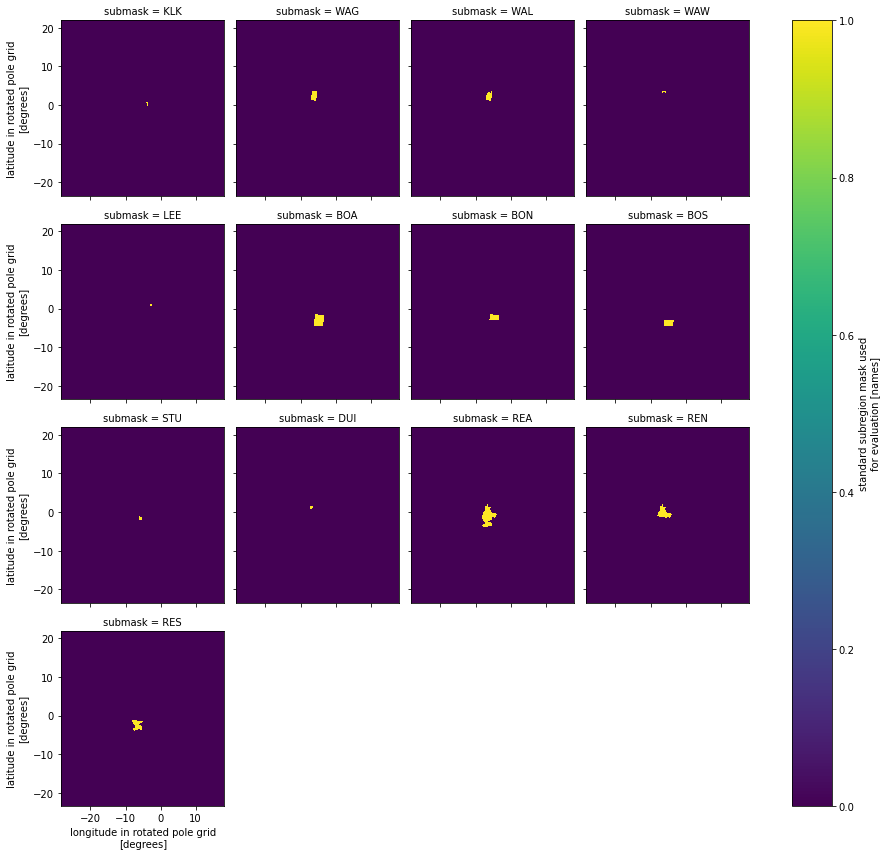

In [4]:
mask.MASK.plot(col="submask", col_wrap=4)

### mask all regions

In [8]:
def plot(da, title=""):
    import cartopy.crs as ccrs
    import cartopy.feature as cf
    import matplotlib.pyplot as plt

    plt.figure(figsize=(20, 10))
    projection = ccrs.PlateCarree()
    transform = ccrs.RotatedPole(pole_latitude=pollat, pole_longitude=pollon)
    # ax = plt.axes(projection=projection)
    ax = plt.axes(projection=transform)
    # ax.set_extent([ds_sub.rlon.min(), ds_sub.rlon.max(), ds_sub.rlat.min(), ds_sub.rlat.max()], crs=transform)
    ax.gridlines(
        draw_labels=True,
        linewidth=0.5,
        color="gray",
        xlocs=range(-180, 180, 1),
        ylocs=range(-90, 90, 1),
    )
    da.plot(
        ax=ax,
        cmap="terrain",
        transform=transform,
        vmin=-200,
        vmax=1000,
        x="rlon",
        y="rlat",
    )
    ax.coastlines(resolution="50m", color="black", linewidth=1)
    ax.add_feature(cf.BORDERS)

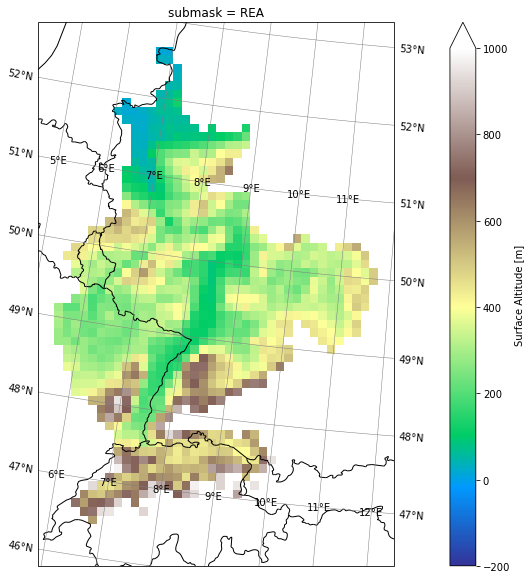

In [9]:
plot(ds.orog.where(mask.MASK.sel(submask="REA"), drop=True))

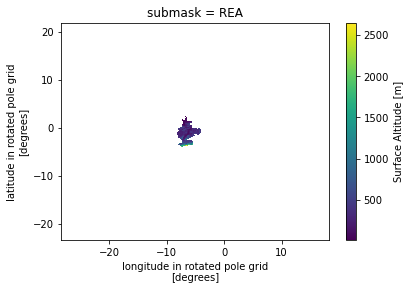

In [10]:
masked_oro = ds.orog.where(mask.MASK)
masked_oro
masked_oro.sel(submask="REA").plot()

### combination of all regions

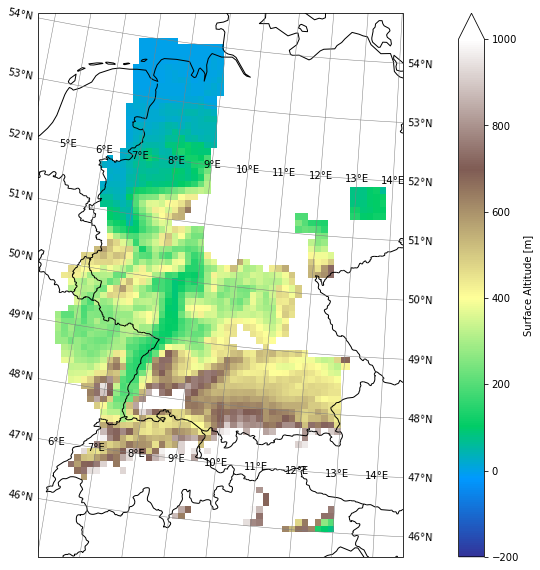

In [13]:
sum_mask = mask.MASK.sum(dim="submask")
plot(ds.orog.where(sum_mask, drop=True))

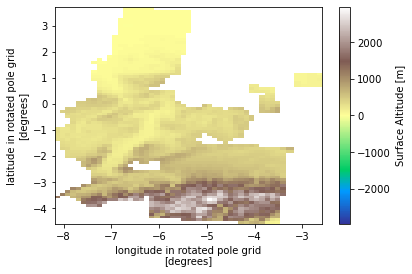

In [14]:
ds.orog.where(sum_mask, drop=True).plot(cmap="terrain")

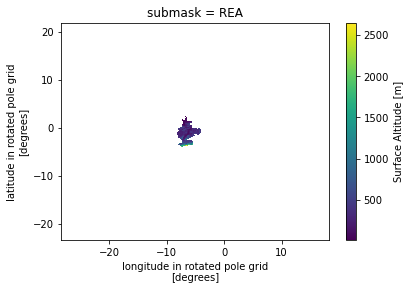

In [15]:
rea = masked_oro.sel(submask="REA").plot()

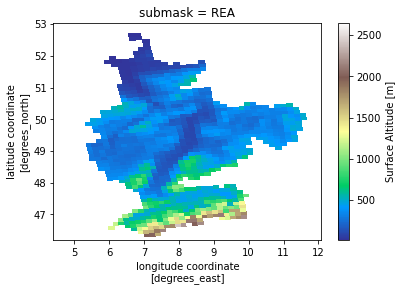

In [16]:
ds.orog.where(mask.MASK.sel(submask="REA"), drop=True).plot(
    cmap="terrain", x="lon", y="lat"
)

### plot all regions on lat lon grid

In [17]:
import matplotlib.pyplot as plt

# Subplots are organized in a Rows x Cols Grid
# Tot and Cols are known
Tot = len(mask.submask)
Cols = 4
# Compute Rows required
Rows = Tot // Cols
Rows += Tot % Cols
# Create a Position index
Position = range(1, Tot + 1)

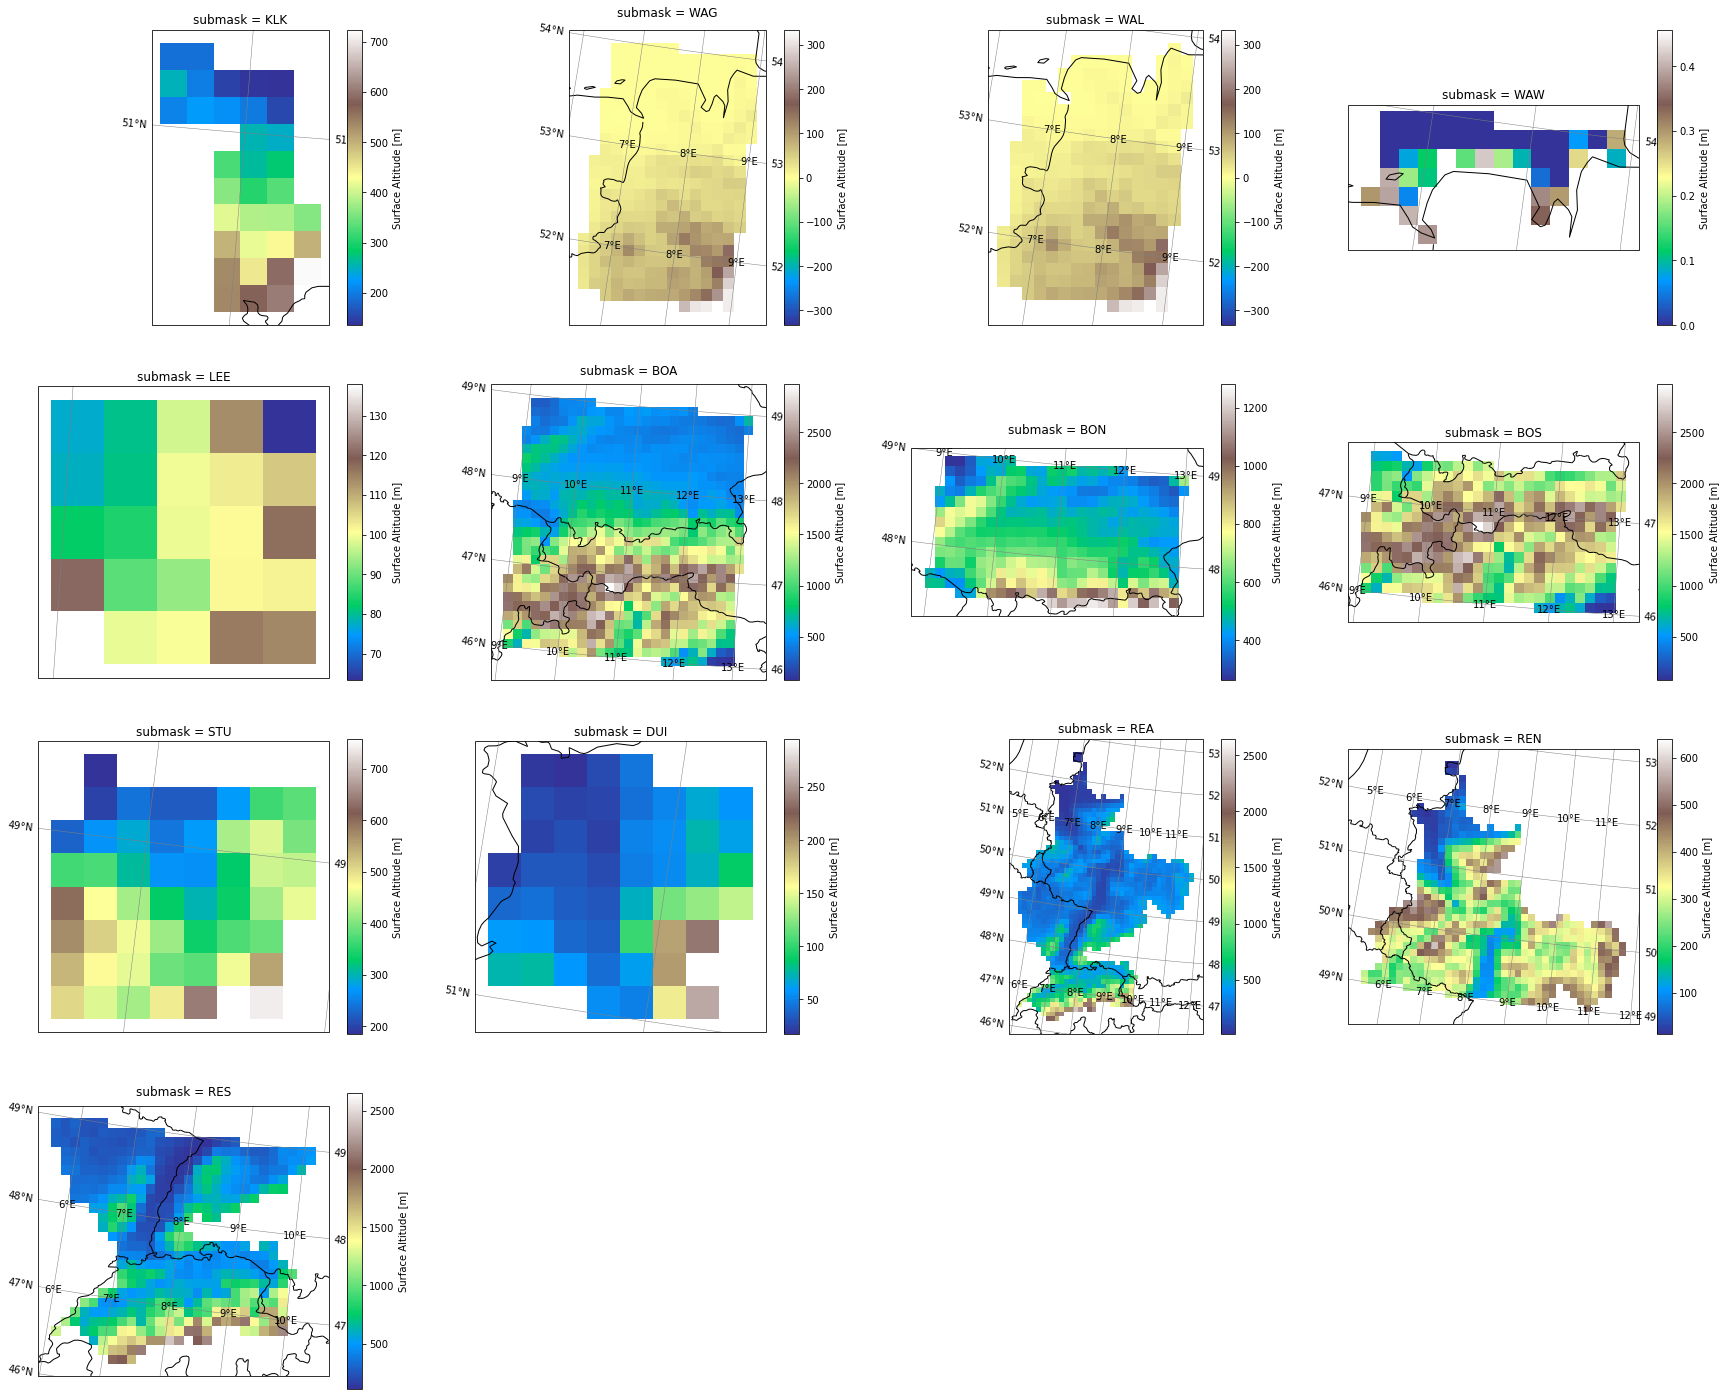

In [22]:
# Create main figure
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(30, 25))
transform = ccrs.RotatedPole(pole_latitude=pollat, pole_longitude=pollon)

for k in range(Tot):
    # add every single subplot to the figure with a for loop
    ax = fig.add_subplot(Rows, Cols, Position[k], projection=transform)
    ax.gridlines(
        draw_labels=True,
        linewidth=0.5,
        color="gray",
        xlocs=range(-180, 180, 1),
        ylocs=range(-90, 90, 1),
    )
    ax.coastlines(resolution="50m", color="black", linewidth=1)
    ax.add_feature(cf.BORDERS)
    subregion = mask.MASK.isel(submask=k)
    ds.orog.where(subregion, drop=True).plot(
        ax=ax, cmap="terrain", x="rlon", y="rlat", transform=transform
    )